### Визуализация результатов кластеризации

#### Диаграмма рассеяния

In [1]:
# Импорт библиотек
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
# дендограмма
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# импортируем библиотеку clustergram
from clustergram import Clustergram

# 3-D визуализация
from mpl_toolkits.mplot3d import Axes3D

import plotly
import plotly.express as px

# импортируем агломеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [2]:
# Загрузка данных
df = pd.read_csv("data/airbnb.csv")
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


<Axes: xlabel='latitude', ylabel='longitude'>

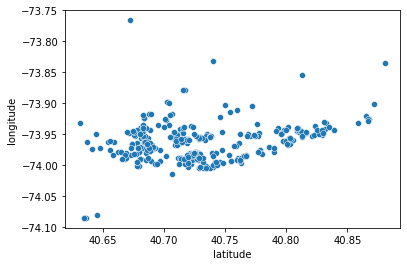

In [3]:
# Быстрая визуализация
sns.scatterplot(x=df.latitude, y=df.longitude)

Распределим данные по кластерам и визуализируем в цвете

In [4]:
# инициализация KMeans
kmeans_clustering = KMeans(n_clusters=6)

# Обучим модель и сохраним данные в датафрейме дополнительным столбцом
predictions = kmeans_clustering.fit_predict(df[['latitude', 'longitude']])

# запишем данные кластеризации в датасет
df['clusters'] = predictions

In [5]:
# методом cluster_centers_ найдем координаты центроидов кластеров и сохраним их в список
centroids = kmeans_clustering.cluster_centers_
centroids

array([[ 40.67793717, -73.96783737],
       [ 40.81224059, -73.94380529],
       [ 40.73554273, -73.98886414],
       [ 40.72094452, -73.95219016],
       [ 40.70287176, -73.89678235],
       [ 40.637372  , -74.084466  ]])

In [6]:
# для каждого из шести центроидов сохраним координаты по отдельности в два списка х и y
centroid_x = [i[0] for i in centroids]
centroid_y = [i[1] for i in centroids]

'''centroid_x = []
centroid_y = []
for i in centroids:
    centroid_x.append(i[0])
    centroid_y.append(i[1])
    
centroid_x'''

'centroid_x = []\ncentroid_y = []\nfor i in centroids:\n    centroid_x.append(i[0])\n    centroid_y.append(i[1])\n    \ncentroid_x'

In [7]:
# зададим цвета для кластеров
colors = ['#DF2020', '#81DF20', '#2095DF', '#DF20C8', '#20DFC5', '#DF8520']
# создадим словари под координаты центроидов и цвет, что бы соотнести их
centroid_x_dict = {}
centroid_y_dict = {}
colors_dict = {}

# создаем цикл из 6 итераций т.к. у нас 6 центроидов с номерами от 0 до 5
for i in range(6):
    # в словарь с координатами по Х будем добавлять значения, где ключ = номеру от 0 до 5, а значение координаты Х
    centroid_x_dict[i] = centroid_x[i]
    # также формирует словарь по коорднате Y
    centroid_y_dict[i] = centroid_y[i]
    # формируем словарь с цветами, где ключ - значение от 0 до 5, а значение - код цвета
    colors_dict[i] = colors[i]

#display('X', centroid_x_dict, 'Y', centroid_y_dict, 'colors', colors_dict)

In [8]:
# в дата сет добавим новые сроки через map (мапинг по столбцу с номером кластера), т.е. каждой точке координаты своего центроида и свой цвет
df['cen_x'] = df.clusters.map(centroid_x_dict)
df['cen_y'] = df.clusters.map(centroid_y_dict)
df['colors'] = df.clusters.map(colors_dict)
#df.head()

<Axes: xlabel='latitude', ylabel='longitude'>

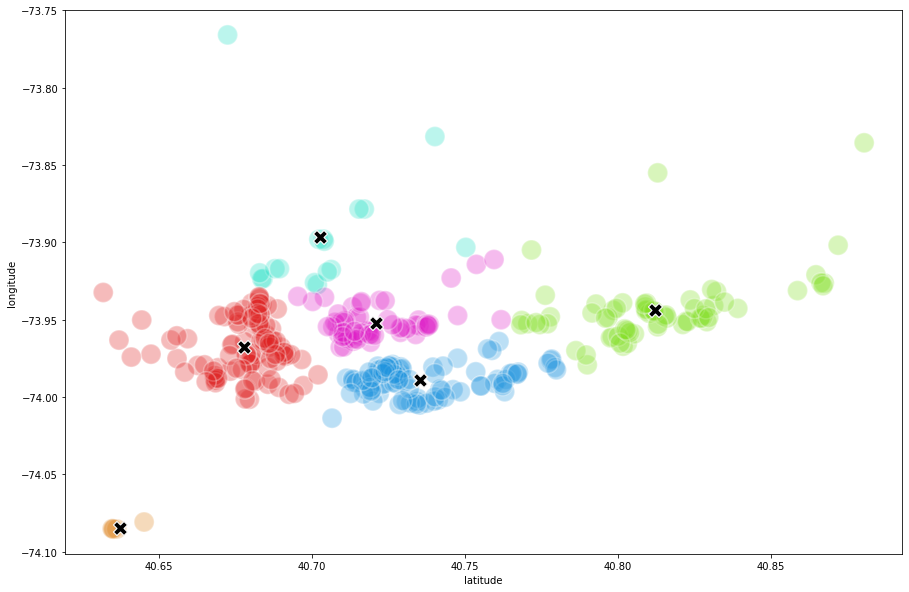

In [9]:
# еще раз запускаем быструю визуализацию диаграммой рассеяния (можно использовать автоцвет c=df.clusters)
#fig, scatter = plt.subplots(figsize = (15,10))
fig, axes = plt.subplots(figsize=(15,10))

# настройка визуализации. s-размер точек, alpha-прозрачность точек
sns.scatterplot(x=df.latitude, y=df.longitude, c=df.colors, s=400, alpha=0.3)

# визуализируем центроиды. Отметим их на схеме Х и зададим черный цвет
sns.scatterplot(x=centroid_x, y=centroid_y, c=['#000000'], s=200, marker='X')

#### Convex Hull (Выпуклая оболочка)

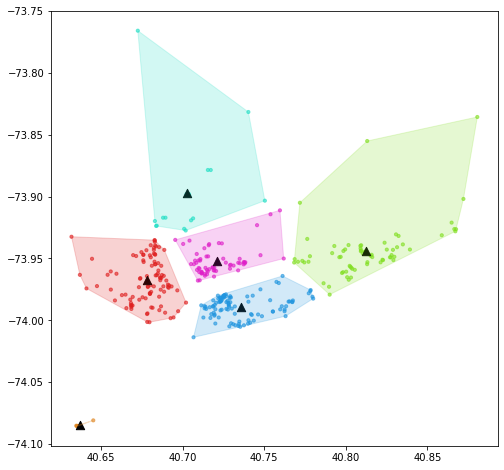

In [10]:
fig, ax = plt.subplots(1, figsize = (8, 8))

# визуализируем объекты коастеров и центроиды
plt.scatter(df.latitude, df.longitude, c=df.colors, alpha = 0.6, s=10)
plt.scatter(centroid_x, centroid_y, marker='^', c=['#000000'], s=70)

# найдем уникальные значения кластеров и пройдемся по ним циклом
for i in df.clusters.unique():
    # запишем в points значения широты и долготы, принадлежащие к i-ному кластеру
    points = df[df.clusters == i][['latitude', 'longitude']].values
    
    # инициализируем метод построения выпуклой оболочки
    hull = ConvexHull(points)
    
    # Запишем координаты оболочки по оси x. Из hull.vertices узнаем индексы элементов, входящих в оболочку.
    # Так как оболочка должна быть замкнутой, то в конце добавляем ещё раз нулевой элемент.
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0]) 
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])
    
    # рисуем оболочку и заливаем её таким же цветом, как и объекты кластера
    plt.fill(x_hull, y_hull, alpha=0.2, c=colors[i])
    

#### Дендограмма - иерархическая агломеративная кластеризация

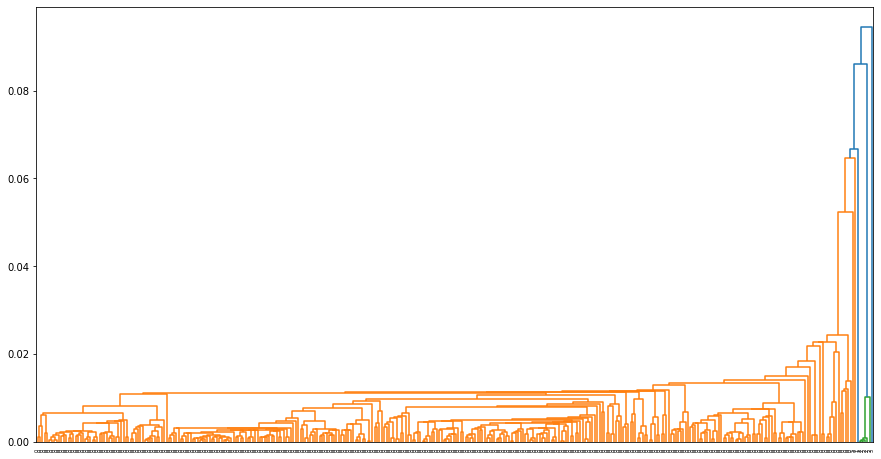

In [23]:
# запускаем агломеративную кластеризацию, расстояние между кластерами рассчитываем методом одиночной связи
agglomerative_clustering = AgglomerativeClustering(n_clusters=6, linkage='single')

# обучаем модель и получаем результаты кластеризации
predictions_ag_model = agglomerative_clustering.fit_predict(df[['latitude', 'longitude']])

# рассчитаем расстояния между кластерами
linked = linkage(df[["latitude", "longitude"]], 'single')

plt.figure(figsize=(15, 8))

# визуализируем дендрограмму с ориентацией top
# сначала будут отрисовываться кластеры с минимальным расстоянием между ними
dendrogram(Z=linked,
            orientation='top',
            labels=predictions_ag_model,
            distance_sort='descending')

plt.show()

#### Clustergramm

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.269 seconds.
K=3 fitted in 0.045 seconds.
K=4 fitted in 0.059 seconds.
K=5 fitted in 0.067 seconds.
K=6 fitted in 0.066 seconds.
K=7 fitted in 0.069 seconds.
K=8 fitted in 0.085 seconds.


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

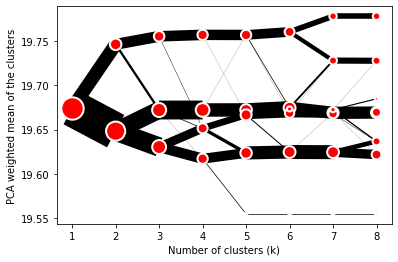

In [12]:
# импортируем библиотеку clustergram
from clustergram import Clustergram

# задаём количество кластеров, для которых хотим получить визуализацию, определяем метод кластеризации
cgram = Clustergram(range(1, 9), method='kmeans')

# запускаем алгоритм
cgram.fit(df[["latitude", "longitude"]])
cgram.plot()

#### 3-D Визуализация

In [13]:
# инициализируем k-means-кластеризацию с шестью кластерами
kmeans_clustering = KMeans(n_clusters=6)

# обучим k-means-модель кластеризации на данных широты, долготы и цены, сохраним данные о кластерах для этих данных в kmeans_predictions
kmeans_predictions = kmeans_clustering.fit_predict(df[['latitude', 'longitude', 'price']])

# сохраним предсказания в колонку clusters датафрейма
df['clusters_3d'] = kmeans_predictions

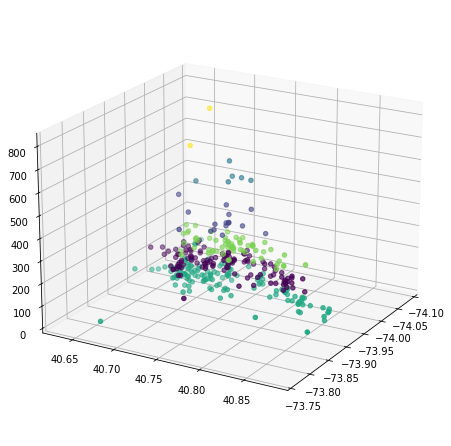

In [14]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)

ax.azim = 30
ax.elev = 20

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(df.longitude.to_list(), df.latitude.to_list(), df.price.to_list(), c=df.clusters_3d)

# добавим оси
#ax.set_xlabel('longitude')
#ax.set_ylabel('latitude')
#ax.set_zlabel('price')

In [17]:
# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
# в значение color передаём номера кластеров
fig = px.scatter_3d(
    data_frame=df, 
    x = 'longitude', 
    y = 'latitude', 
    z = 'price', 
    color='clusters', 
    width=1000,
    height=700
)

#отображаем график
fig.show()

Задание 8.4<br>
Для датасета Airbnb проведите иерархическую агломеративную кластеризацию с использованием sklearn. В качестве признаков для кластеризации используйте latitude и longitude из датафрейма, количество кластеров для кластеризации — 6. Расстояние между кластерами рассчитайте методом полной связи, направление дендрограммы — top.

Визуализируйте дендрограмму для проведённой кластеризации. На сколько кластеров можно разделить датасет, если расстояние между кластерами будет равно 0.25?

Ответ:3


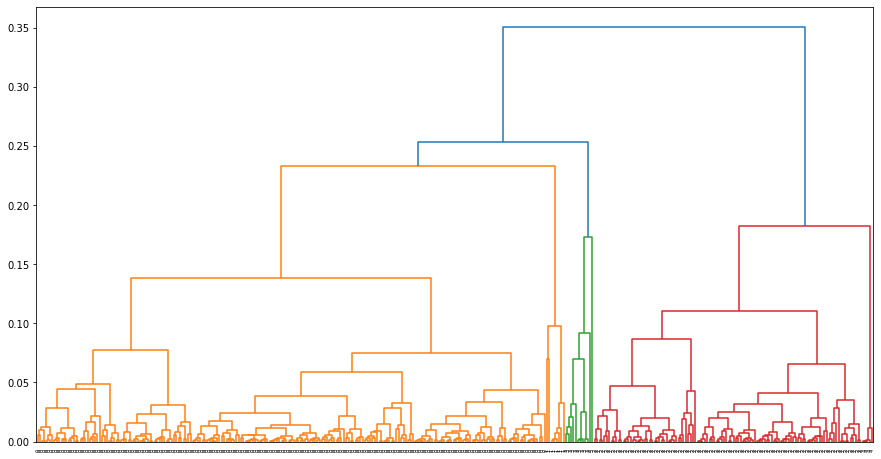

In [31]:
print('Ответ:3')
# запускаем агломеративную кластеризацию, расстояние между кластерами рассчитываем методом одиночной связи
agglomerative_clustering = AgglomerativeClustering(n_clusters=6, linkage='complete')

# обучаем модель и получаем результаты кластеризации
predictions_ag_model = agglomerative_clustering.fit_predict(df[['latitude', 'longitude']])

# рассчитаем расстояния между кластерами
linked = linkage(df[["latitude", "longitude"]], 'complete')

plt.figure(figsize=(15, 8))

# визуализируем дендрограмму с ориентацией top
# сначала будут отрисовываться кластеры с минимальным расстоянием между ними
dendrogram(Z=linked,
            orientation='top',
            labels=predictions_ag_model,
            distance_sort='descending')

plt.show()
